- Written on 7 September 2018 by Raunak
- The input trajectories to this file need to have `laneNum` as one of the attributes of the dictionary containing the actual data in the traj_lab_dict data structure

In [1]:
%matplotlib inline

import collections
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import gaussian_kde
from scipy.stats import entropy

import hgail.misc.utils

import utils
import visualize_utils

from copy import deepcopy

In [2]:
def filename2label(fn):
    s = fn.find('-') + 1
    e = fn.find('.')
    return fn[s:e]

In [3]:
filenames = [i for i in utils.NGSIM_FILENAME_TO_ID.keys() if '101' in i]

In [4]:
expert_filepath = '../../data/trajectories/ngsim_addLaneID.h5'

expert = dict()
for fn in filenames:
    t = filename2label(fn)
    print("fn:", fn, "t:", t)
    expert[t] = utils.load_data(
        expert_filepath, 
        min_length=250, 
        normalize_data=False, 
        clip_std_multiple=10.,
        ngsim_filename=fn
    )

fn: trajdata_i101_trajectories-0820am-0835am.txt t: 0820am-0835am
fn: trajdata_i101_trajectories-0805am-0820am.txt t: 0805am-0820am
fn: trajdata_i101_trajectories-0750am-0805am.txt t: 0750am-0805am


In [15]:
# Detective work on the expert stuff loaded in using utils.load_data
print(expert.keys())
print(type(expert['0750am-0805am']))
print(expert['0750am-0805am'].keys())
print(type(expert['0750am-0805am']['observations']))
print(expert['0750am-0805am']['observations'].shape)
print(expert['0750am-0805am']['observations'][124556][0])

dict_keys(['0820am-0835am', '0805am-0820am', '0750am-0805am'])
<class 'dict'>
dict_keys(['obs_mean', 'obs_std', 'observations', 'actions'])
<class 'numpy.ndarray'>
(1109861, 67)
2.0


In [5]:
x, names = utils.load_x_feature_names(
    expert_filepath, 'trajdata_i101_trajectories-0750am-0805am.txt')

In [7]:
observation_indexes = dict([(names[i], i) for i in range(len(names))])

In [9]:
# Detective work on the expert stuff loaded in through 
# load_x_feature_names
#print(names)
print(type(x))
print(x.shape) # The shape obtained from utils.load_x_feature_names
print(x[0][2200][0])
print(names)
print(observation_indexes['is_colliding'])

<class 'numpy.ndarray'>
(2150, 2286, 67)
0.0
['laneid' 'relative_offset' 'relative_heading' 'velocity' 'length' 'width'
 'lane_curvature' 'markerdist_left' 'markerdist_right' 'accel' 'jerk'
 'turn_rate_global' 'angular_rate_global' 'turn_rate_frenet'
 'angular_rate_frenet' 'timegap' 'timegap_is_avail' 'time_to_collision'
 'time_to_collision_is_avail' 'is_colliding' 'out_of_lane'
 'negative_velocity' 'distance_road_edge_left' 'distance_road_edge_right'
 'lidar_1' 'lidar_2' 'lidar_3' 'lidar_4' 'lidar_5' 'lidar_6' 'lidar_7'
 'lidar_8' 'lidar_9' 'lidar_10' 'lidar_11' 'lidar_12' 'lidar_13' 'lidar_14'
 'lidar_15' 'lidar_16' 'lidar_17' 'lidar_18' 'lidar_19' 'lidar_20'
 'rangerate_lidar_1' 'rangerate_lidar_2' 'rangerate_lidar_3'
 'rangerate_lidar_4' 'rangerate_lidar_5' 'rangerate_lidar_6'
 'rangerate_lidar_7' 'rangerate_lidar_8' 'rangerate_lidar_9'
 'rangerate_lidar_10' 'rangerate_lidar_11' 'rangerate_lidar_12'
 'rangerate_lidar_13' 'rangerate_lidar_14' 'rangerate_lidar_15'
 'rangerate_lidar_1

In [78]:
# Suppress scientific painful notation in printing
np.set_printoptions(suppress=True)
#print(names)
#print(x[2000,271,:])
print(x[:,:,0].shape)

(2150, 2286)


In [15]:
# Copied over from emergent metrics code. The function to calculate emergent stuff
def calc_offroad(traj):
    return float(len(traj['observations'][:,observation_indexes['out_of_lane']][
        np.where(np.isclose(traj['observations'][:,observation_indexes['out_of_lane']],1))
    ]))/ float(len(traj['observations']))

# in case we want to use a different threshold for whatever reason
def calc_offroad_manual(traj, thresh = -1.0): 
    num_offroad = float(len(traj['observations'][:,0][
        np.where(np.minimum(
            traj['observations'][:,observation_indexes['distance_road_edge_left']], \
            traj['observations'][:,observation_indexes['distance_road_edge_right']]) <= thresh)
        ]))
    return num_offroad / float(len(traj['observations']))

def calc_hard_brake(traj, thresh = -3.0):
    #traj should be unnormalized
    return float(len(traj['observations'][:,observation_indexes['accel']][np.where(\
                traj['observations'][:,observation_indexes['accel']] <= thresh)])) \
                / float(len(traj['actions']))

def calc_collisions(traj, expert=True, H=200, nveh=100, verbose = True):
    if expert:
        if verbose:
            print("shape = ",traj['observations'].shape)
            print("shape of is_colliding column = ",\
                  traj['observations'][:,observation_indexes['is_colliding']].shape)
            print("len(traj[obs]) = ",len(traj['observations']))
        return float(len(traj['observations'][:,observation_indexes['is_colliding']][
            np.where(np.isclose(traj['observations'][:,observation_indexes['is_colliding']],1))
        ]))/ float(len(traj['observations']))
    else:
        a = np.reshape(
            traj['observations'][:,observation_indexes['is_colliding']], (H, nveh))[:50,:]
        return np.mean(np.any(np.isclose(a, 1.0), axis=1))

In [16]:
calc_collisions(expert['0750am-0805am'])

shape =  (1109861, 67)
shape of is_colliding column =  (1109861,)
len(traj[obs]) =  1109861


0.0021444126787048107

In [20]:
# Let's experiment with the 'expert' gotten using load_data as opposed to that 
# gotten from load_x_feature_names
myTraj = expert['0750am-0805am']
print(myTraj.keys())
print(myTraj['observations'][:,observation_indexes['laneid']].shape)
explaneids = myTraj['observations'][:,observation_indexes['laneid']]
print(explaneids[:300])

dict_keys(['observations', 'obs_std', 'actions', 'obs_mean'])
(1109861,)
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2

## Here begins lane change stuff

In [91]:
# Extracting lane change rate for the ngsim data
laneChangeNgsimData = x[:,:,0]
print(laneChangeNgsimData[0,2000:2290])

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

In [92]:
# Notice the transpose here. Looks like rows store the agent number and columns store the time
ngsimLaneChangeRate = calcLaneChangeRateFor1Simulation(
np.transpose(laneChangeNgsimData),n_agents = laneChangeNgsimData.shape[0],\
    max_steps = laneChangeNgsimData.shape[1], verbose=False)
print(ngsimLaneChangeRate)

# Dividing by number of timesteps
print(ngsimLaneChangeRate/laneChangeNgsimData.shape[1])

4.193023255813953
0.0018342183971189648


## Here begins anaysis of our trained policies

In [4]:
# Name the policy to be analyzed

model_labels = [
    #'rails_smoothed_off_brake_1000_2_fine'
    'multiagent_curr_1_fine'
]

n_itrs = dict([(i, 1000) for i in model_labels])
for i in model_labels:
    if 'fine' in i:
        n_itrs[i] = 200

In [5]:
# Load the policy to be analyzed
traj_lab_dict = \
visualize_utils.get_trajs_dict(
model_labels, files_to_use = \
[utils.NGSIM_FILENAME_TO_ID[i] - 1 for i in filenames])

valdirs, params_filepaths = \
visualize_utils.get_val_dirs_and_params_paths_d(
model_labels,n_itrs)

In [35]:
print("keys of the dictionary \n",\
      traj_lab_dict[model_labels[0]][0][0][0].keys())

keys of the dictionary 
 dict_keys(['is_colliding', 'rmse_vel', 'observations', 'rewards', 'is_offroad', 'rmse_pos', 'log_std', 'laneNum', 'hard_brake', 'mean', 'prev_action', 'rmse_t', 'actions'])


In [6]:
meriDict = traj_lab_dict[model_labels[0]][0][0][0]
laneInfoArray = meriDict['laneNum']
print("lane array shape = ",laneInfoArray.shape)

lane array shape =  (200, 100)


In [9]:
# This should be 3, corresponding to the 3 time windows
# aka 750-805, 805-810 and 810-825
print(len(traj_lab_dict[model_labels[0]][0]))

3


In [10]:
# This should be 100, corresponding to the 100 sims that we run
# within the 1st time window i.e 750-805
print(len(traj_lab_dict[model_labels[0]][0][0]))

100


In [6]:
# Let's give this list a name as it is useful
listOfSims4TimeWindow1 = traj_lab_dict[model_labels[0]][0][0]

## All lane changes are counted in the incrementation

In [7]:
# Comparing two timesteps all cars in one go
def calcLaneChangeRateFor1Simulation(dataArray,\
                                     n_agents = 100, max_steps = 200,\
                                    verbose = False):
    prevLaneNumsVector = np.zeros(n_agents)
    numLaneChanges = 0
    
    for step in range(max_steps):
        currentLaneNumsVector = dataArray[step,:]
        if verbose:
            # This should be (n_agents,100)
            print(currentLaneNumsVector.shape)
            
        laneChangesVector = currentLaneNumsVector - prevLaneNumsVector
        numLaneChanges += np.count_nonzero(laneChangesVector)
        
        prevLaneNumsVector = currentLaneNumsVector
    
    # Plot the lanes at the end of the 20 second simulation
    if verbose:
        print(currentLaneNumsVector)
        plt.plot(currentLaneNumsVector)
    
    return numLaneChanges/n_agents

In [8]:
# Calculation for 1 simulation
testLaneChangeRate = calcLaneChangeRateFor1Simulation(
listOfSims4TimeWindow1[76]['laneNum'], verbose=False)
print(testLaneChangeRate)

1.89


In [9]:
# Calculate lane change rate for every simulation and then average the result
laneChangeRateArray = np.zeros(len(listOfSims4TimeWindow1))
for i in range(len(listOfSims4TimeWindow1)):
    laneChangeRateArray[i] = \
    calcLaneChangeRateFor1Simulation(listOfSims4TimeWindow1[i]['laneNum'])
print(np.mean(laneChangeRateArray))

# Dividing by the number of timesteps
print(np.mean(laneChangeRateArray)/200)

1.9696
0.009848


## At least one lane change means increment by 1

In [10]:
# Let's try the per car logic over one whole simulation
def calcCarWiseLaneChangeRateForOneSim(dataArray,\
                                     n_agents = 100, max_steps = 200,\
                                    verbose = False):
    
    if verbose:
        print("Number of cars = ",dataArray.shape[1])
    
    # Assume all cars have not changed lane to start with
    carHasChangedLane = np.zeros(dataArray.shape[1])
    
    
    # Iterate over all the columns of the data array
    # aka all the cars one by one
    for i in range(dataArray.shape[1]):
        # Compare all elements of that column i.e. lane id in all
        # timesteps to the top column i.e lane id in 1st timestep
        # If they are not all equal, then the car i has at least one
        # lane change so increment lane change counter by 1
        # i.e. this particular car has changed lane once in the
        # 20 second time window under consideration
        if not(
            np.all(np.isclose(dataArray[:,i],dataArray[0,i]))):
            
            carHasChangedLane[i] = 1
    
    numCarsThatHaveChangedLanes = np.sum(carHasChangedLane)
    return numCarsThatHaveChangedLanes/n_agents

In [11]:
testLaneChangeRate = calcCarWiseLaneChangeRateForOneSim(
listOfSims4TimeWindow1[17]['laneNum'],verbose=True)
print(testLaneChangeRate)

Number of cars =  100
0.57


In [48]:
# Let's plot the lane id to see whether that on-ramp or off-ramp is
# causing problems
def plotCarLaneIDOverTime(dataArray,carNum,verbose=True):
    if verbose:
        print("Selected car number is ",carNum)
    plt.plot(dataArray[:,carNum])

Selected car number is  27


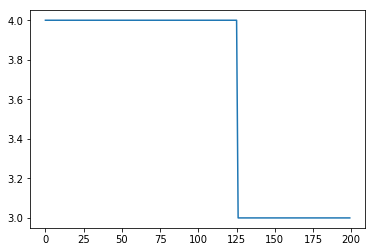

In [75]:
plotCarLaneIDOverTime(
    listOfSims4TimeWindow1[17]['laneNum'],27,verbose=True)